##please run this on colab to test first## 

In [3]:
# mount the collab drive 
from google.colab import drive
drive.mount('/content/gdrive')

# install the required packages 
!pip install onnx
!pip install onnxruntime

# import the required items 
import onnx
import onnxruntime as ort
import time
import numpy as np
import torch
import torchvision
import cv2
from PIL import Image

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.1 MB/s 


In [44]:
# simple function to load a single image 
def load_image_into_numpy_array(path, height, width):
    """
    Load an image from file into a numpy array.

    Args:
      path: the file path to the image
      height: height of image
      width: width of image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3), (original_height, original_width)
    """
    image = Image.open(path).convert("RGB")
    image_shape = np.asarray(image).shape

    image_resized = image.resize((width, height))
    return np.array(image_resized), (image_shape[0], image_shape[1])

# simple function to read the label file label.pbtxt
def load_label_map(label_map_path):
    """
    Reads label map in the format of .pbtxt and parse into dictionary

    Args:
      label_map_path: the file path to the label_map

    Returns:
      dictionary with the format of {label_index: {'id': label_index, 'name': label_name}}
    """
    # creates the empty dictionary
    label_map = {}

    with open(label_map_path, "r") as label_file:
        for line in label_file:
            if "id" in line:
                label_index = int(line.split(":")[-1])
                label_name = next(label_file).split(":")[-1].strip().strip("'")
                label_map[label_index] = {
                    "id": label_index,
                    "name": label_name,
                }
    # outputs the dictionary of the label values 
    return label_map

def post_process(rows_8400, num_classes, conf_thre=0.0001, nms_thre=0.3, print_info=False):
    # makes a copy of the input 
    prediction = np.copy(rows_8400)
    # convert the copy to a tensor 
    prediction = torch.Tensor(prediction)

    if print_info == True:
        print('Here is the input shape:',prediction.shape, '\n')
        print('Here is the input data:','\n',prediction, '\n')

    # make a placeholder tensor of normal distribution/random values 
    # we use this tensor to hold our calculated box positions temporarily 
    box_corner = prediction.new(prediction.shape)
    if print_info == True:
        print('here is the created placeholder tensor:','\n',box_corner, '\n')

    # perform some column maths magic to get the values for boxes location
    # col 0 - col 2 
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    # col 1 - col 3 
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    # col 0 + col 2 
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    # col 1 + col 3 
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    # replace with new format 
    prediction[:, :, :4] = box_corner[:, :, :4]
    # show the new prediction 
    if print_info == True:
        print('here is the updated 8400 rows of tensor with adjusted box coordinates:','\n',prediction, '\n')

    # trail and error to find the right column to start 
    x_fac = 6

    # print the class probabilities
    if print_info == True:
        print('here are the class probabilities:','\n',prediction[:, :, x_fac: x_fac + num_classes], '\n')
    
    # need to adjust the dimension based on the number of input classes 
    if num_classes > 1:
        dims = 2
    else:
        dims = 0
    print(dims)
    # get the class confidence and the index of the predicted class 
    class_conf, class_pred = torch.max(prediction[:, :, x_fac: x_fac + num_classes], dims, keepdim=True)

    # get the masking for the rows above conf_thre
    conf_mask = (prediction[:,:, 4] * class_conf.squeeze() >= conf_thre).squeeze()

    # output the numebr of rows that are >= conf_thre
    rows_picked = 0 
    for i in conf_mask: 
        if i == True:
            rows_picked += 1

    if print_info == True:
        print('rows picked based on confidence threshold:',rows_picked, '\n')

    # concat all the newly prepared data into a new output tensor 
    detections = torch.cat((prediction[:, :, :5], class_conf, class_pred.float()), 2)

    # apply masking to the 8400 rows, we only keep thos rows with > conf_thres 
    detections = detections[:,conf_mask,:]
    if print_info == True:
        print('after masking:','\n', detections)

    # apply the NMS to reduce the number of overlapping boxes 
    d = detections[:, :, :4]
    d = d.view(len(detections[0]), 4)
    d.shape

    s = detections[:, :, 4] * detections[:, :, 5]
    s = s.view(len(detections[0]))
    s.shape

    id = detections[:, :, 6]
    id = id.view(len(detections[0]))
    id.shape
    
    # aglgorithm here 
    nms_out_index = torchvision.ops.batched_nms(
        d,
        s,
        id,
        nms_thre,
    )
    if print_info == True:
        print('after NMS, rows pickedfor plotting:','\n',nms_out_index, '\n')
    
    # apply the NMS masking 
    output = detections[0][nms_out_index]

    # return the final output 
    return output

##Enter parameters below:##

In [107]:
# only a single picture can be inferred at a time ! 
# please adapt the code accordingly 
# enter the paths to the required files here:
# model_path = '/content/gdrive/My Drive/Colab Notebooks/604_vision/ONNX/model.onnx'
# image_path = '/content/gdrive/My Drive/Colab Notebooks/604_vision/ONNX/boat460.png'
# label_path = '/content/gdrive/My Drive/Colab Notebooks/604_vision/ONNX/label_map.pbtxt'
model_path = '/content/gdrive/My Drive/Colab Notebooks/604_vision/ONNX/sea/model.onnx'
image_path = '/content/gdrive/My Drive/Colab Notebooks/604_vision/ONNX/sea/picture_1.jpg'
label_path = '/content/gdrive/My Drive/Colab Notebooks/604_vision/ONNX/sea/label_map.pbtxt'

# enter the required details below 
width = 640
height = 640
num_classes=3
conf_thre=0.1
nms_thre=0.10

In [108]:
# test model 
onnx_model = onnx.load(model_path)
onnx.checker.check_model(onnx_model)

# Load model
print("Loading model...")
start_time = time.time()
session = ort.InferenceSession(model_path)
print("Model loaded, took {} seconds...".format(time.time() - start_time))

# get the name of the input and output 
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

## Returned resized + original picture in the format of width, height
image_resized, origi_shape = load_image_into_numpy_array(image_path, int(width), int(height))

# preprocess the resized image so we can input them proper 
input_image = np.expand_dims(image_resized.astype(np.float32).transpose(2,0,1),0)

## Feed image into model
ort_outs = session.run([output_name],{input_name: input_image})

# show the ouput
ort_outs[0][0][0:3]

Loading model...
Model loaded, took 0.3128781318664551 seconds...


array([[ 3.2329228e+00, -8.7542874e-01,  9.1471519e+00,  6.2253771e+00,
         8.2999468e-05,  6.8991482e-03,  1.2358040e-02,  6.1596036e-03,
         1.2959659e-02],
       [ 1.2724537e+01, -2.5736208e+00,  7.6128998e+00,  5.6795325e+00,
         3.0159950e-05,  8.0158710e-03,  1.0979623e-02,  7.0576072e-03,
         9.6629858e-03],
       [ 2.1023495e+01, -2.2254632e+00,  6.3887396e+00,  5.0535483e+00,
         2.0027161e-05,  1.0628372e-02,  1.1432439e-02,  6.6396892e-03,
         8.7830126e-03]], dtype=float32)

In [109]:
output = post_process(ort_outs[0], num_classes, conf_thre=conf_thre, nms_thre=nms_thre, print_info=False)
if output.shape[0] == 0:
    print('no bounding boxes were identified !')
output

2


tensor([[ 2.4207e+02,  1.7631e+02,  2.7701e+02,  2.1652e+02,  9.6885e-01,
          9.4063e-01,  1.0000e+00],
        [ 1.0507e+01,  1.2118e+02,  9.8957e+01,  1.9235e+02,  9.6375e-01,
          7.1432e-01,  1.0000e+00],
        [ 2.0420e+02,  2.0553e+02,  2.6748e+02,  2.5010e+02,  5.9998e-01,
          8.3478e-01,  1.0000e+00],
        [ 2.7292e+02,  3.3066e+02,  3.6342e+02,  3.9143e+02,  8.0845e-01,
          5.5022e-01,  1.0000e+00],
        [ 1.0138e+00,  7.8159e+01,  1.0648e+02,  1.6202e+02,  9.5438e-01,
          3.6340e-01,  2.0000e+00],
        [ 2.8397e+02,  4.3884e+02,  3.5783e+02,  4.8157e+02,  4.2090e-01,
          7.0039e-01,  1.0000e+00],
        [ 3.2041e+02,  5.4957e+02,  3.6949e+02,  5.8283e+02,  4.3428e-01,
          6.4380e-01,  1.0000e+00],
        [ 2.7758e+02,  2.7923e+02,  3.3194e+02,  3.2111e+02,  2.9035e-01,
          6.8075e-01,  1.0000e+00],
        [ 3.7500e+02,  1.3686e+02,  4.1883e+02,  1.7190e+02,  2.0849e-01,
          9.3783e-01,  1.0000e+00],
        [ 

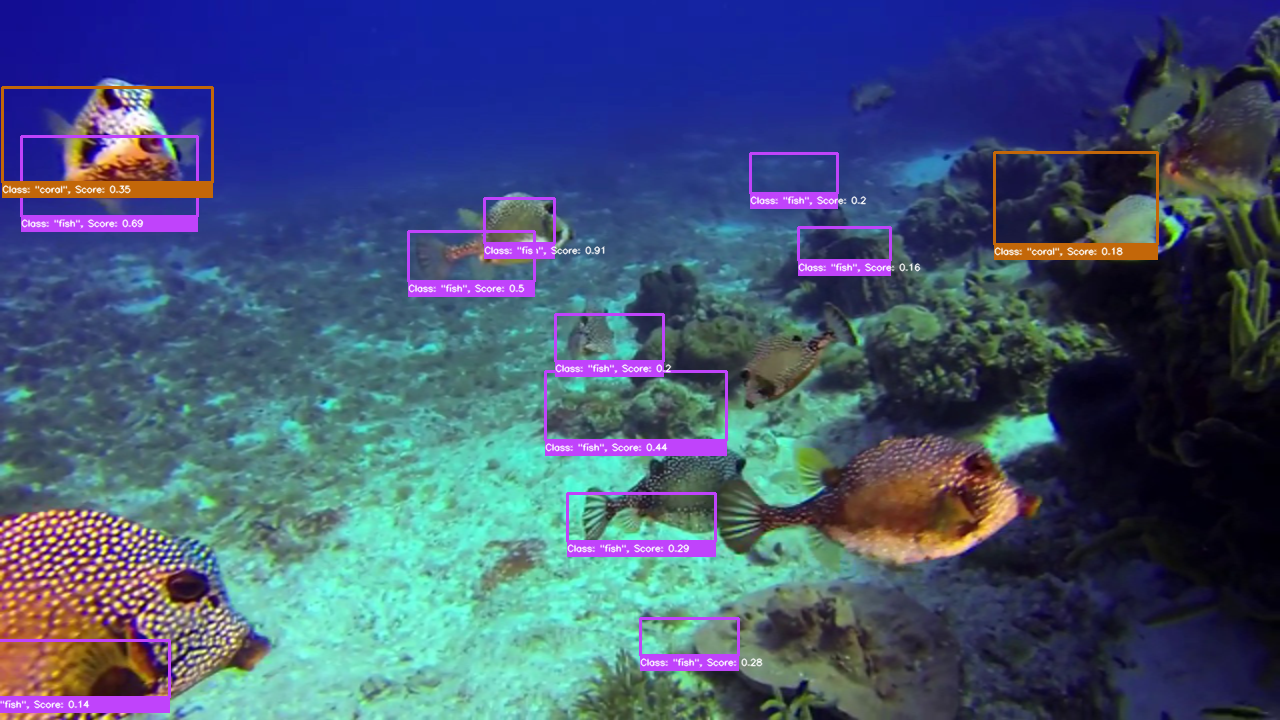

In [110]:
# get the plotting information from the post processed outputs 
bboxes = output[:, 0:4].cpu().detach().numpy().astype(np.float64)
classes = output[:,6].cpu().detach().numpy().astype(np.float64)
scores = (output[:,4]*output[:,5]).cpu().detach().numpy().astype(np.float64)

# perform some simple maths 
bboxes = [
    [   bbox[1]/height,
        bbox[0]/width,
        bbox[3]/height,
        bbox[2]/width,
    ]
    for bbox in bboxes
]

# get the original image 
image_origi = Image.fromarray(image_resized).resize((origi_shape[1], origi_shape[0]))
# make into numpy array
image_origi = np.array(image_origi)

## Load label map
category_index = load_label_map(label_path)
category_index

np.random.seed(0)
## Load color map
color_map = {}
for each_class in range(len(category_index)):
    color_map[each_class] = [
                            int(np.random.choice(range(256))),
                            int(np.random.choice(range(256))), 
                            int(np.random.choice(range(256))),
    
        # int(i) for i in np.random.choice(range(256), size=3)
]

# plot all the boxes for our current picture
for idx, each_bbox in enumerate(bboxes):
    color = color_map.get(classes[idx])
    # print('plotted box',idx)
    # print('color:',color)

    ## Draw bounding box
    cv2.rectangle(
        image_origi,
        (
            int(each_bbox[1] * origi_shape[1]),
            int(each_bbox[0] * origi_shape[0]),
        ),
        (
            int(each_bbox[3] * origi_shape[1]),
            int(each_bbox[2] * origi_shape[0]),
        ),
        color,
        2,
    )

    ## Draw label background
    cv2.rectangle(
        image_origi,
        (
            int(each_bbox[1] * origi_shape[1]),
            int(each_bbox[2] * origi_shape[0]),
        ),
        (
            int(each_bbox[3] * origi_shape[1]),
            int(each_bbox[2] * origi_shape[0] + 15),
        ),
        color,
        -1,
    )

    ## Insert label class & score
    cv2.putText(
        image_origi,
        "Class: {}, Score: {}".format(
            str(category_index[classes[idx]+1]["name"]),
            str(round(scores[idx], 2)),
        ),
        (
            int(each_bbox[1] * origi_shape[1]),
            int(each_bbox[2] * origi_shape[0] + 10),
        ),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.3,
        (255, 255, 255),
        1,
        cv2.LINE_AA,
    )

    image_predict = Image.fromarray(image_origi)
image_predict